In [1]:
%matplotlib inline

# Built-in
import csv
import os
import re

# Scientific/ML libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shap
shap.initjs()

# IPython display
from IPython.display import Markdown, display

# Scipy
from scipy.stats import chi2_contingency

# Scikit-learn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# AIF360 fairness library
from aif360.datasets import BinaryLabelDataset
from aif360.explainers import MetricTextExplainer
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import EqOddsPostprocessing, RejectOptionClassification
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing


# Seed for reproducibility
np.random.seed(1)


C:\Users\artem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


# Load Base Cleaned/Encoded Data

In [2]:
df = pd.concat([pd.read_csv('dataset/train_test_extracted_base/train.csv'), pd.read_csv('dataset/train_test_extracted_base/val.csv')])
df.head

<bound method NDFrame.head of        race  gender  age  admission_type_id  discharge_disposition_id  \
0         1       0   75                  3                         6   
1         3       0   75                  1                         1   
2         3       1   85                  1                         1   
3         1       1   45                  1                         1   
4         3       0   85                  2                        22   
...     ...     ...  ...                ...                       ...   
10144     3       0   75                  3                         1   
10145     3       0   65                  1                         1   
10146     3       0   85                  6                        25   
10147     3       1   85                  3                         1   
10148     1       1   75                  1                        18   

       admission_source_id  time_in_hospital  medical_specialty  \
0                        1

# Correlation Visualization

In [3]:
numeric_columns = df.columns
correlation_matrix = df[numeric_columns].corr()
print(correlation_matrix)

                              race    gender       age  admission_type_id  \
race                      1.000000  0.057765  0.146152           0.097053   
gender                    0.057765  1.000000 -0.051716           0.017319   
age                       0.146152 -0.051716  1.000000          -0.006655   
admission_type_id         0.097053  0.017319 -0.006655           1.000000   
discharge_disposition_id  0.001371 -0.021459  0.115639           0.083073   
...                            ...       ...       ...                ...   
diag_3_Injury             0.009853  0.011434 -0.001428           0.009703   
diag_3_Muscoloskeletal    0.006003 -0.016781 -0.005040           0.017678   
diag_3_Neoplasms          0.008318  0.011166  0.028590          -0.002317   
diag_3_Other             -0.007298 -0.008291 -0.135090          -0.021872   
diag_3_Respiratory        0.023855  0.001714  0.041397          -0.014900   

                          discharge_disposition_id  admission_source_id  \


In [4]:
# Correlation with readmitted patients
correlation_with_readmitted = df.corr()['readmitted']
sorted_correlation_readmitted = correlation_with_readmitted.abs().sort_values(ascending=False)
sorted_correlation_readmitted = sorted_correlation_readmitted[1:]
print(sorted_correlation_readmitted)

number_inpatient                     0.165333
number_emergency                     0.062108
discharge_disposition_id             0.051486
number_diagnoses                     0.051414
time_in_hospital                     0.047732
                                       ...   
glimepiride_pioglitazone_medicine    0.001220
diag_3_Injury                        0.001099
glipizide_metformin_medicine         0.001075
miglitol_medicine                    0.000757
diag_1_Genitourinary                 0.000094
Name: readmitted, Length: 71, dtype: float64


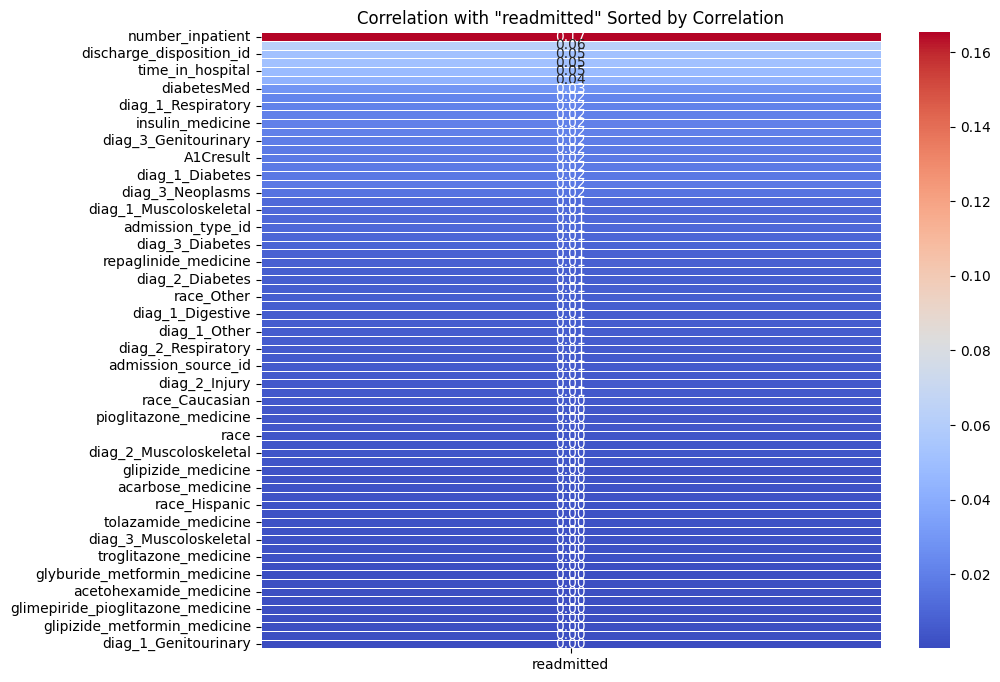

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_correlation_readmitted.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with "readmitted" Sorted by Correlation')
plt.show()

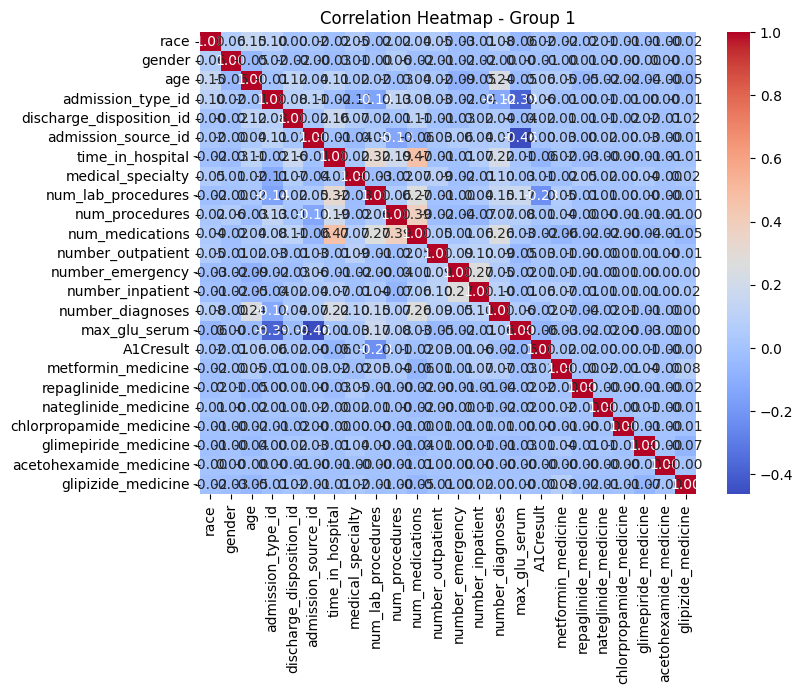

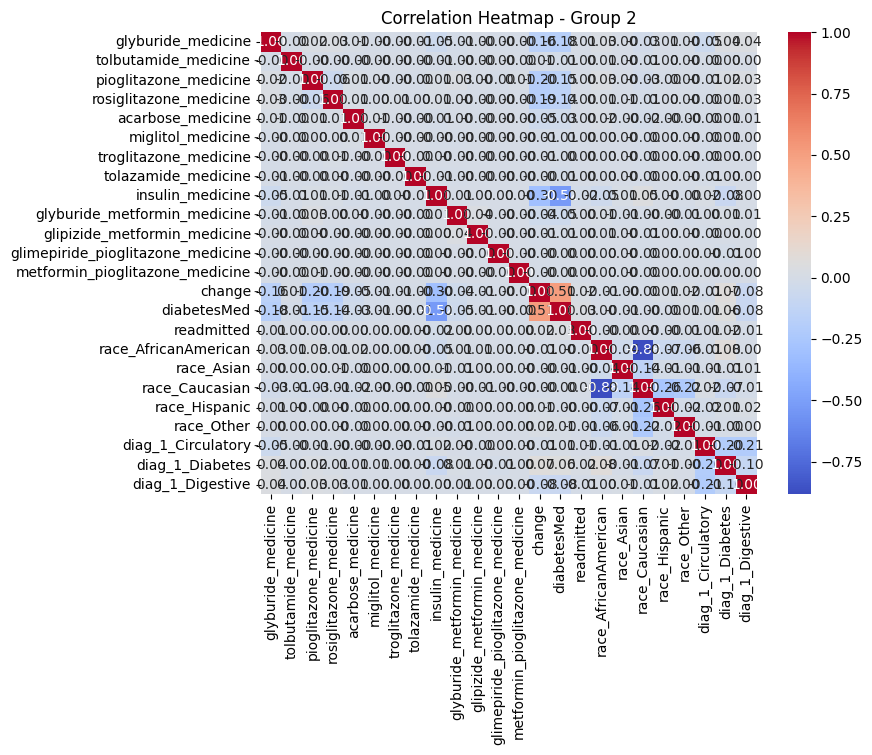

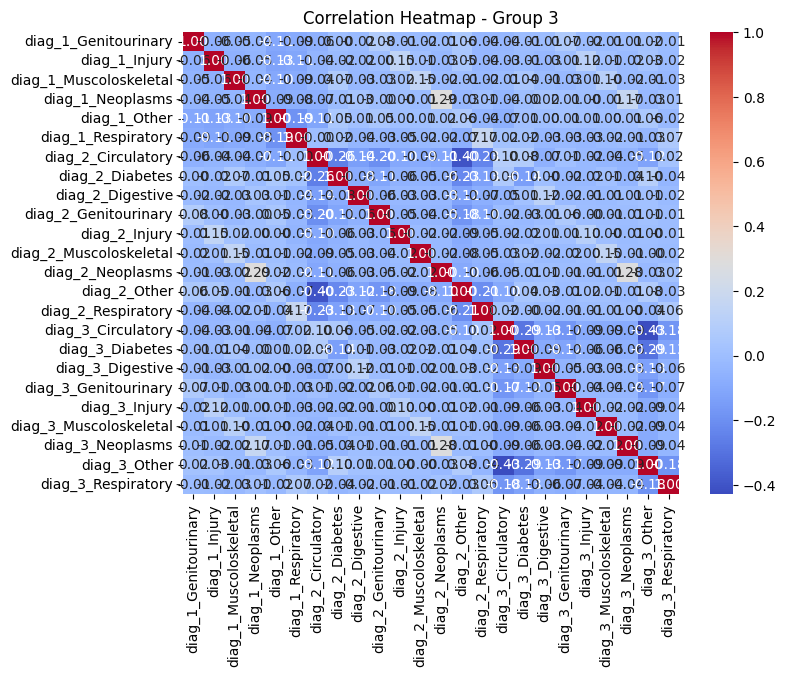

In [6]:
# Heatmap Visualization
num_columns = len(correlation_with_readmitted)
group_size = num_columns // 3  # number of columns per group

# split the columns into three groups for better visibility
group_1 = correlation_with_readmitted[:group_size].index  # first group
group_2 = correlation_with_readmitted[group_size:2*group_size].index  # second group
group_3 = correlation_with_readmitted[2*group_size:].index  # third group

group_1_matrix = df[group_1].corr()
group_2_matrix = df[group_2].corr()
group_3_matrix = df[group_3].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(group_1_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Group 1")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(group_2_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Group 2")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(group_3_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Group 3")
plt.show()

In [7]:
# # Correlation with age
# correlation_with_age = df.corr()['age']
# sorted_correlation_age = correlation_with_age.abs().sort_values(ascending=False)
# sorted_correlation_age = sorted_correlation_age[1:]
# print(sorted_correlation_age)

In [8]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(sorted_correlation_age.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title('Correlation with "age" Sorted by Correlation')
# plt.show()

In [9]:
# Correlation with race
correlation_with_race = df.corr()['race']
sorted_correlation_race = correlation_with_race.abs().sort_values(ascending=False)
sorted_correlation_race = sorted_correlation_race[1:]
print(sorted_correlation_race)

race_AfricanAmerican        0.888921
race_Caucasian              0.864165
race_Other                  0.364301
race_Hispanic               0.233938
age                         0.146152
                              ...   
discharge_disposition_id    0.001371
tolazamide_medicine         0.001331
change                      0.001049
diag_1_Genitourinary        0.000734
diag_1_Other                0.000025
Name: race, Length: 71, dtype: float64


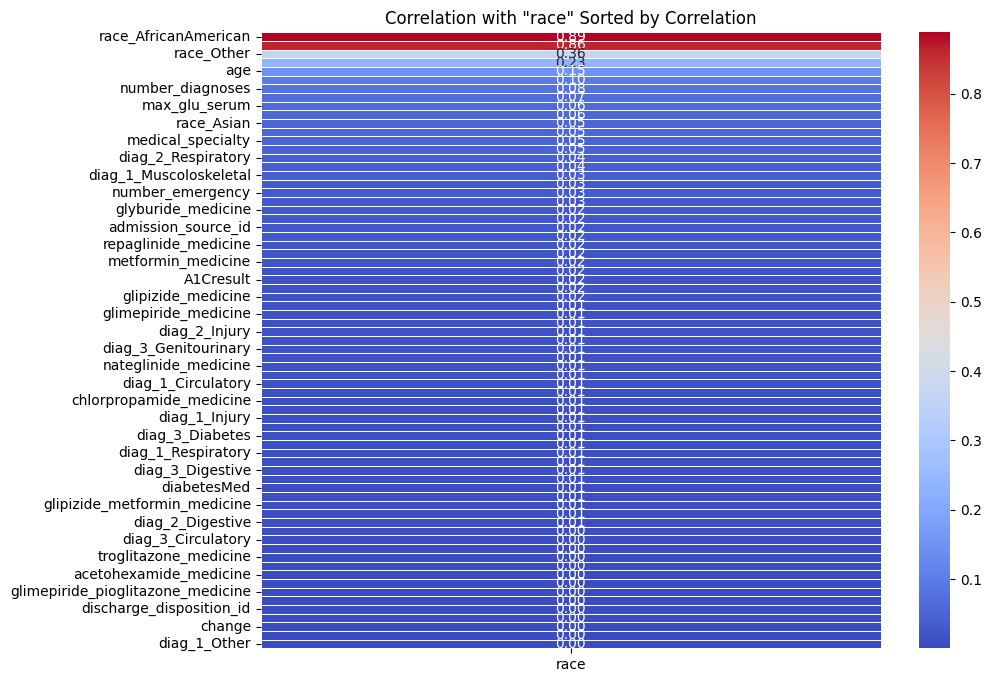

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_correlation_race.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with "race" Sorted by Correlation')
plt.show()

In [11]:
# Correlation with gender
correlation_with_gender = df.corr()['gender']
sorted_correlation_gender = correlation_with_gender.abs().sort_values(ascending=False)
sorted_correlation_gender = sorted_correlation_gender[1:]
print(sorted_correlation_gender)

race_AfricanAmerican    0.070303
num_procedures          0.062975
race_Caucasian          0.060796
diag_1_Circulatory      0.058405
race                    0.057765
                          ...   
diag_3_Respiratory      0.001714
max_glu_serum           0.001703
glimepiride_medicine    0.001199
diag_2_Injury           0.001059
race_Hispanic           0.000701
Name: gender, Length: 71, dtype: float64


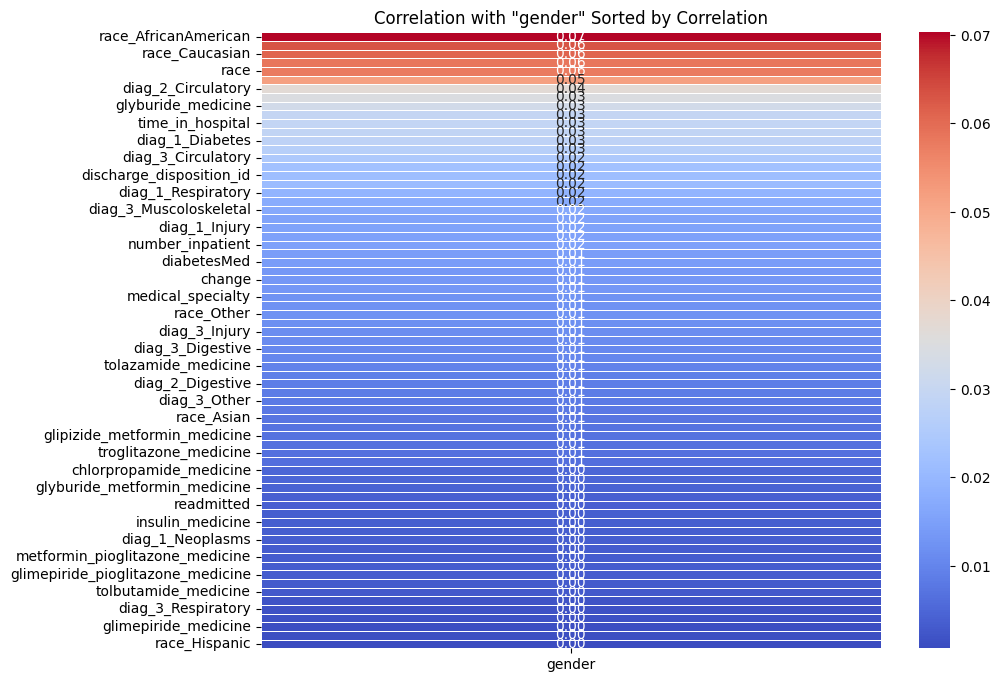

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_correlation_gender.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with "gender" Sorted by Correlation')
plt.show()

# important Feature Extraction with RF and GBM

In [13]:
# helper function for model evaluation

def evaluate_model_and_features(
    X, 
    y, 
    model, 
    feature_names=None, 
    top=20, 
    title="Model", 
    multi_output=False,
    average='binary'
):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    if multi_output:
        model = MultiOutputClassifier(model)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average)
    rec = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    print(f"\n--- {title} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    if multi_output:
        importances = np.mean(
            [est.feature_importances_ for est in model.estimators_], axis=0
        )
    else:
        importances = model.feature_importances_

    if feature_names is None:
        feature_names = np.arange(len(importances))
    else:
        feature_names = np.array(feature_names)

    sorted_idx = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_idx]
    sorted_features = feature_names[sorted_idx]

    print(f"\nTop {top} Features by Importance:")
    for i in range(min(top, len(sorted_features))):
        print(f"{i+1}. {sorted_features[i]} ({sorted_importances[i]:.4f})")

    plt.figure(figsize=(8, 5))
    plt.barh(sorted_features[:top], sorted_importances[:top], color="royalblue")
    plt.xlabel("Feature Importance Score")
    plt.title(f"Top {top} Feature Importances - {title}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    top_feature_data = X.loc[:, sorted_features[:top]]
    corr_matrix = top_feature_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f"Correlation Heatmap of Top {top} Features - {title}")
    plt.tight_layout()
    plt.show()

    return list(sorted_features[:top])



--- Random Forest - Readmitted ---
Accuracy : 0.8896
Precision: 0.8896
Recall   : 0.8896
F1 Score : 0.8896

Top 30 Features by Importance:
1. num_lab_procedures (0.0937)
2. num_medications (0.0824)
3. time_in_hospital (0.0597)
4. age (0.0505)
5. number_inpatient (0.0472)
6. medical_specialty (0.0430)
7. discharge_disposition_id (0.0414)
8. num_procedures (0.0412)
9. number_diagnoses (0.0376)
10. admission_type_id (0.0278)
11. insulin_medicine (0.0253)
12. admission_source_id (0.0251)
13. number_outpatient (0.0207)
14. gender (0.0204)
15. number_emergency (0.0167)
16. A1Cresult (0.0165)
17. diag_2_Circulatory (0.0156)
18. diag_3_Circulatory (0.0153)
19. diag_3_Other (0.0149)
20. diag_2_Other (0.0145)
21. change (0.0133)
22. diag_1_Circulatory (0.0131)
23. race (0.0127)
24. glipizide_medicine (0.0122)
25. diag_1_Other (0.0120)
26. metformin_medicine (0.0117)
27. diag_3_Diabetes (0.0116)
28. glyburide_medicine (0.0104)
29. diag_2_Diabetes (0.0100)
30. race_Caucasian (0.0093)


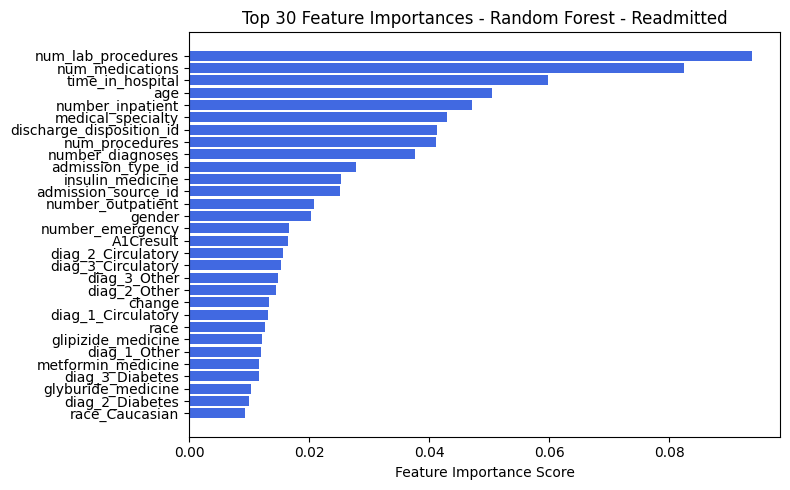

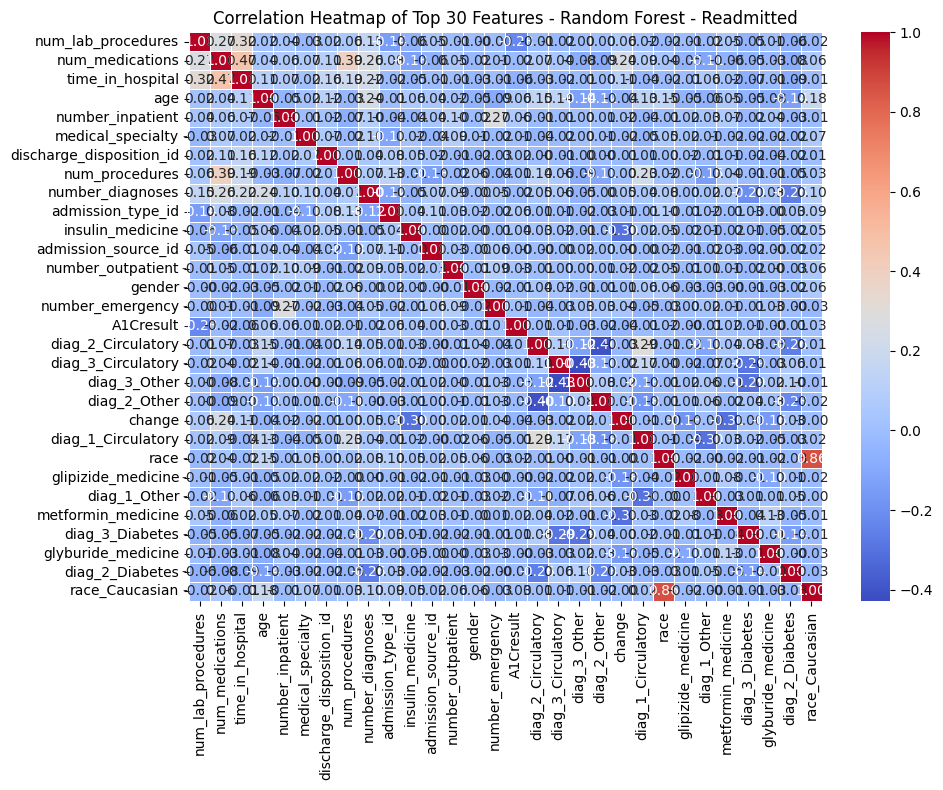

In [14]:
X_readmitted = df.drop(['readmitted'], axis=1)
y_readmitted = df['readmitted']

rf_readmitted = RandomForestClassifier(random_state=42)

top20_features_readmitted = evaluate_model_and_features(
    X_readmitted,
    y_readmitted,
    model=rf_readmitted,
    feature_names=X_readmitted.columns,
    top=30,
    title="Random Forest - Readmitted",
    average='micro'
)



--- Random Forest - Gender ---
Accuracy : 0.5851
Precision: 0.5628
Recall   : 0.4380
F1 Score : 0.4926

Top 20 Features by Importance:
1. num_lab_procedures (0.1009)
2. num_medications (0.0883)
3. time_in_hospital (0.0634)
4. age (0.0539)
5. number_diagnoses (0.0480)
6. medical_specialty (0.0456)
7. num_procedures (0.0421)
8. number_inpatient (0.0347)
9. discharge_disposition_id (0.0335)
10. insulin_medicine (0.0304)
11. admission_type_id (0.0302)
12. admission_source_id (0.0261)
13. number_outpatient (0.0232)
14. A1Cresult (0.0199)
15. change (0.0158)
16. metformin_medicine (0.0158)
17. diag_3_Other (0.0156)
18. number_emergency (0.0148)
19. diag_3_Circulatory (0.0147)
20. diag_2_Other (0.0136)


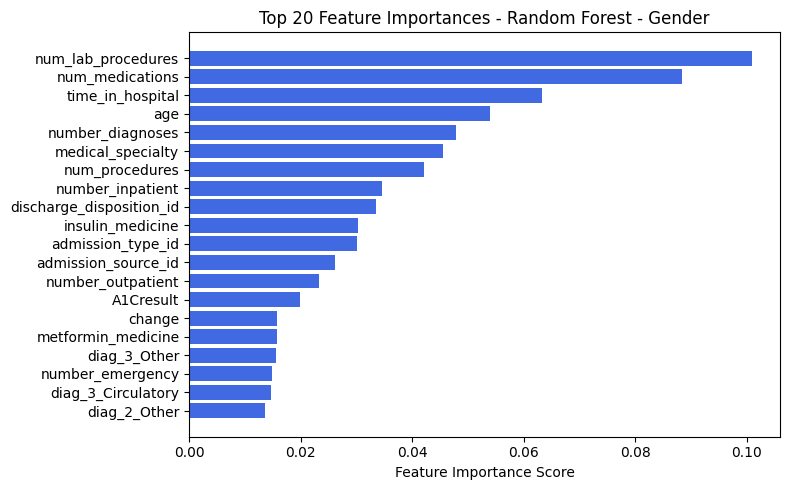

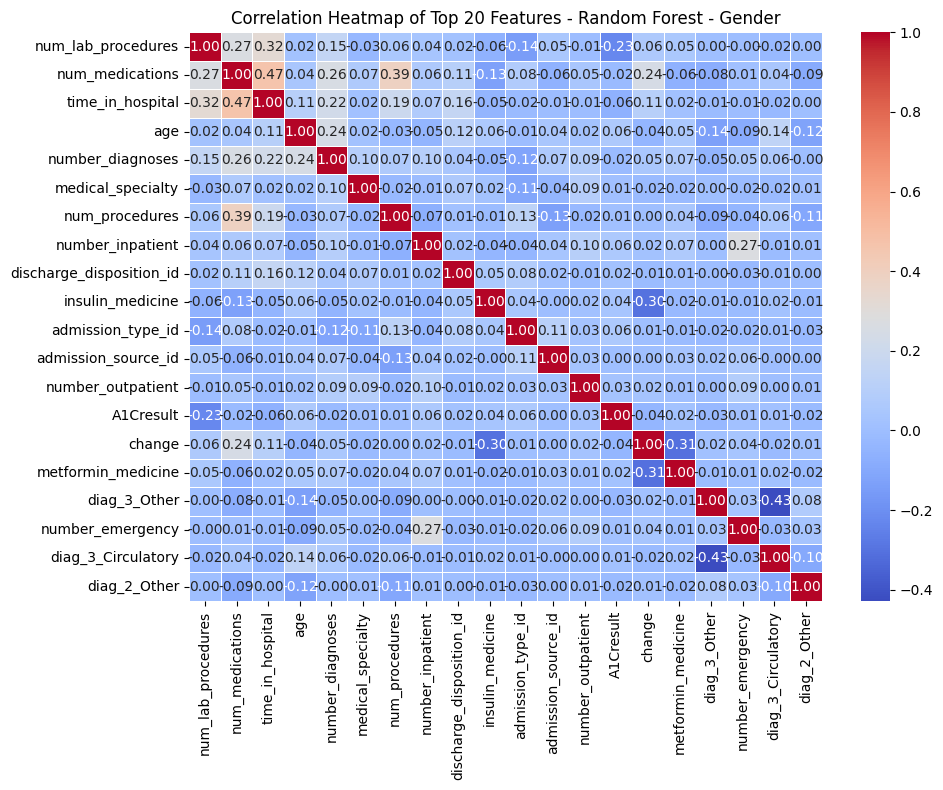

In [15]:
X_gender = df.drop(['gender'], axis=1)
y_gender = df['gender']

rfg = RandomForestClassifier(random_state=42)
top20_features_gender = evaluate_model_and_features(
    X_gender, 
    y_gender, 
    model=rfg, 
    feature_names=X_gender.columns, 
    top=20, 
    title="Random Forest - Gender", 
    multi_output=False,
    average='binary'
)


In [16]:
# X_age = df.drop(['age', 'readmitted'], axis=1)
# y_age = df['age']

# gbm_age = GradientBoostingClassifier(
#     n_estimators=100, 
#     learning_rate=0.1, 
#     max_depth=3, 
#     random_state=42
# )

# top20_features_age = evaluate_model_and_features(
#     X_age, 
#     y_age, 
#     model=gbm_age, 
#     feature_names=X_age.columns,
#     top=20,
#     title="GBM - Age",
#     multi_output=False,
#     average='micro'
# )



--- GBM - Race Labeling (Multi-class) ---
Accuracy : 0.7756
Precision: 0.7756
Recall   : 0.7756
F1 Score : 0.7756

Top 20 Features by Importance:
1. age (0.2618)
2. medical_specialty (0.1687)
3. admission_type_id (0.1157)
4. num_lab_procedures (0.0611)
5. number_diagnoses (0.0444)
6. gender (0.0423)
7. admission_source_id (0.0411)
8. number_outpatient (0.0298)
9. number_emergency (0.0295)
10. num_medications (0.0282)
11. time_in_hospital (0.0210)
12. num_procedures (0.0184)
13. insulin_medicine (0.0169)
14. discharge_disposition_id (0.0169)
15. diag_1_Diabetes (0.0144)
16. diag_2_Circulatory (0.0112)
17. diag_3_Circulatory (0.0088)
18. diag_2_Respiratory (0.0075)
19. number_inpatient (0.0067)
20. metformin_medicine (0.0060)


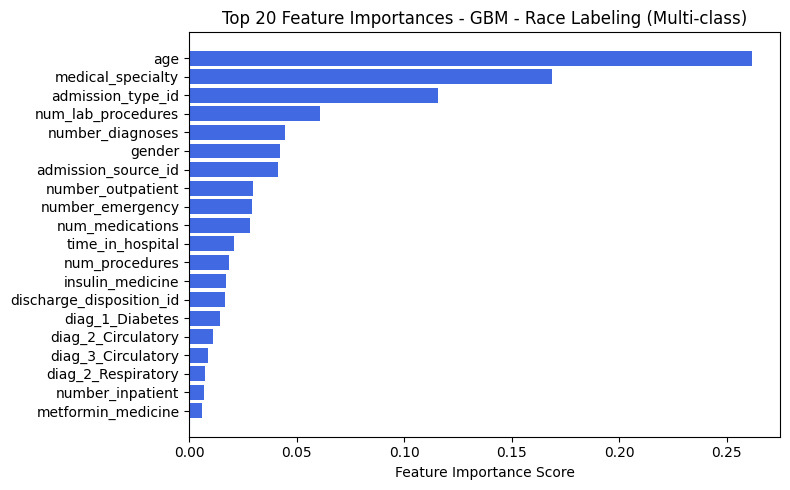

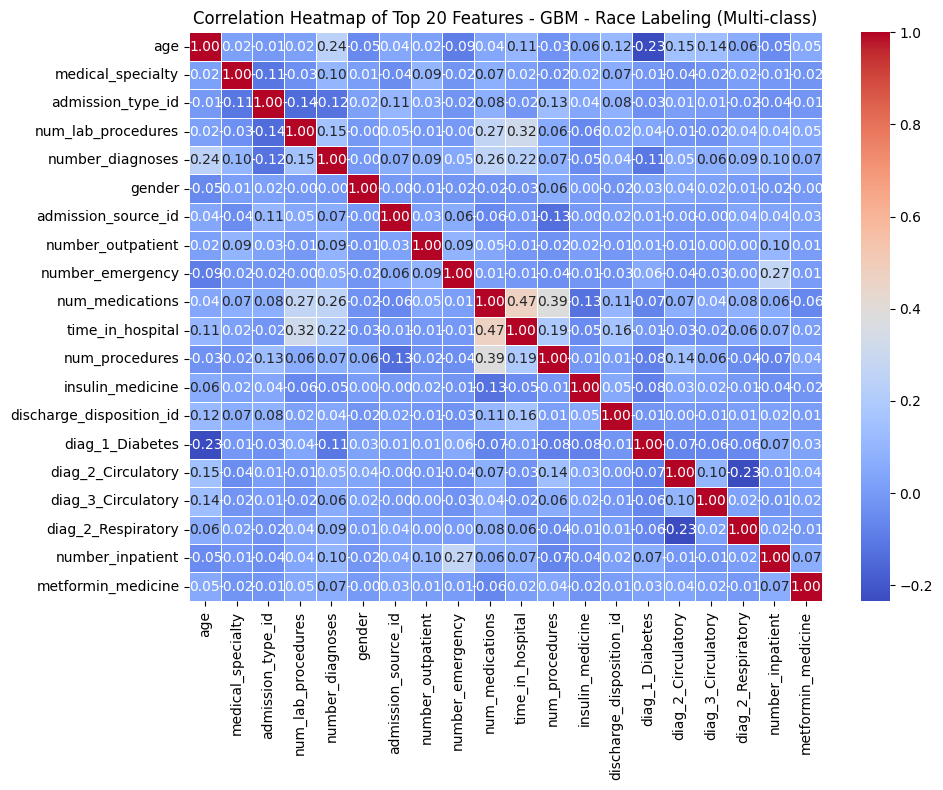

In [17]:
X_race_labeling = df.drop(
    [
        'race',
        'readmitted',
        'race_AfricanAmerican',
        'race_Asian',
        'race_Caucasian',
        'race_Hispanic',
        'race_Other',
    ],
    axis=1
)
y_race_labeling = df['race']

gbr1 = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)

top20_features_race_labeling = evaluate_model_and_features(
    X_race_labeling,
    y_race_labeling,
    model=gbr1,
    feature_names=X_race_labeling.columns,
    top=20,
    title="GBM - Race Labeling (Multi-class)",
    multi_output=False,
    average='micro'
)



--- GBM - Race (Multi-Output Binary) ---
Accuracy : 0.7675
Precision: 0.7783
Recall   : 0.7688
F1 Score : 0.7735

Top 20 Features by Importance:
1. age (0.1703)
2. medical_specialty (0.1551)
3. admission_type_id (0.0805)
4. num_lab_procedures (0.0727)
5. num_medications (0.0703)
6. number_diagnoses (0.0425)
7. admission_source_id (0.0342)
8. number_emergency (0.0339)
9. discharge_disposition_id (0.0260)
10. number_outpatient (0.0250)
11. gender (0.0211)
12. num_procedures (0.0198)
13. time_in_hospital (0.0195)
14. insulin_medicine (0.0183)
15. number_inpatient (0.0164)
16. max_glu_serum (0.0149)
17. diag_2_Digestive (0.0124)
18. A1Cresult (0.0123)
19. diag_1_Diabetes (0.0109)
20. glyburide_metformin_medicine (0.0093)


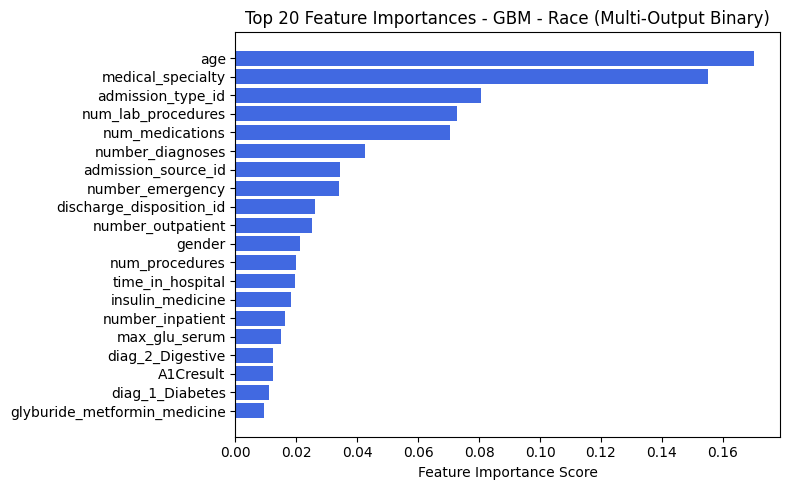

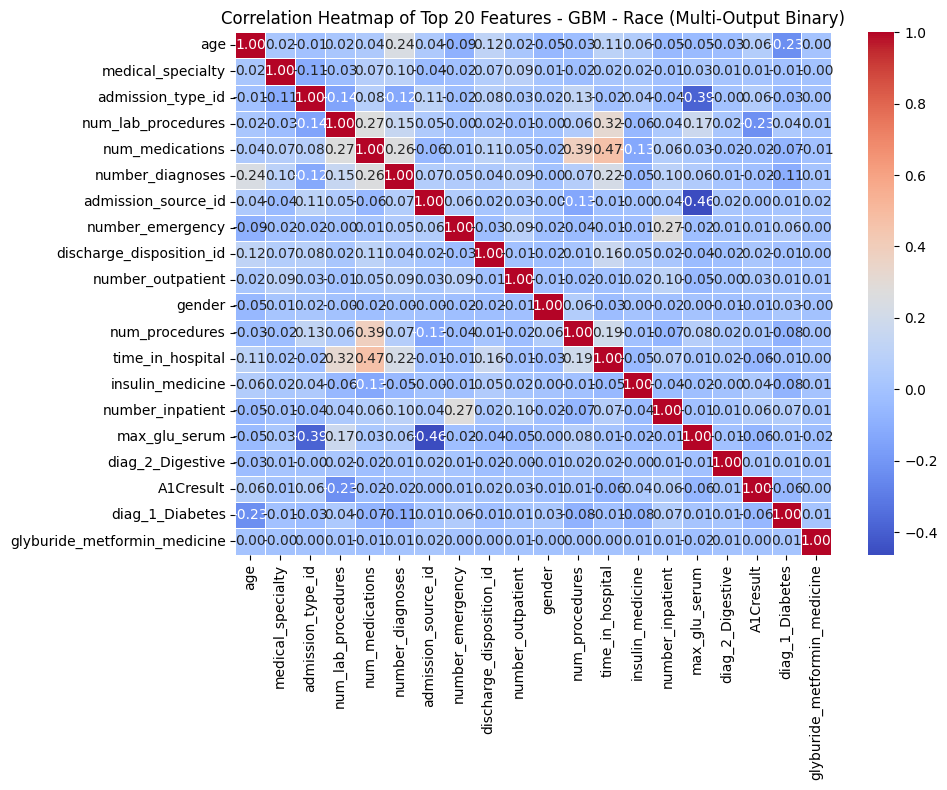

In [18]:
# 2) Multi-output (separate binary columns)
X_race_multi = df.drop(
    [
        'race',
        'race_AfricanAmerican',
        'race_Asian',
        'race_Caucasian',
        'race_Hispanic',
        'race_Other',
        'readmitted' 
    ], 
    axis=1
)

y_race_multi = df[[
    'race_AfricanAmerican',
    'race_Asian',
    'race_Caucasian',
    'race_Hispanic',
    'race_Other'
]]

gbr_multi = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)

top20_features_race_multi = evaluate_model_and_features(
    X_race_multi,
    y_race_multi,
    model=gbr_multi,
    feature_names=X_race_multi.columns,
    top=20,
    title="GBM - Race (Multi-Output Binary)",
    multi_output=True,
    average='micro'
)


## Extract most important feature in classifying readmitted

In [19]:
all_features_related_to_demographics_readmitted = set(top20_features_race_labeling) | set(top20_features_race_multi) | set(top20_features_gender) | set(top20_features_readmitted)


columns_to_remove = {
    'readmitted', 'age', 'gender', 'race', 'race_Caucasian', 'race_Asian', 'race_AfricanAmerican', 'race_Hispanic', 'race_Other', 'medical_specialty', 'admission_type_id', 'admission_source_id'
}

all_features_related_to_demographics_readmitted = all_features_related_to_demographics_readmitted - columns_to_remove
top20_features_readmitted = set(top20_features_readmitted) - columns_to_remove

print("Number of combined features:", len(top20_features_readmitted))
print(top20_features_readmitted)


Number of combined features: 23
{'insulin_medicine', 'number_diagnoses', 'glipizide_medicine', 'diag_3_Diabetes', 'diag_1_Circulatory', 'change', 'discharge_disposition_id', 'metformin_medicine', 'glyburide_medicine', 'diag_1_Other', 'num_medications', 'A1Cresult', 'time_in_hospital', 'num_lab_procedures', 'number_outpatient', 'number_inpatient', 'diag_2_Other', 'number_emergency', 'diag_2_Circulatory', 'num_procedures', 'diag_3_Other', 'diag_3_Circulatory', 'diag_2_Diabetes'}


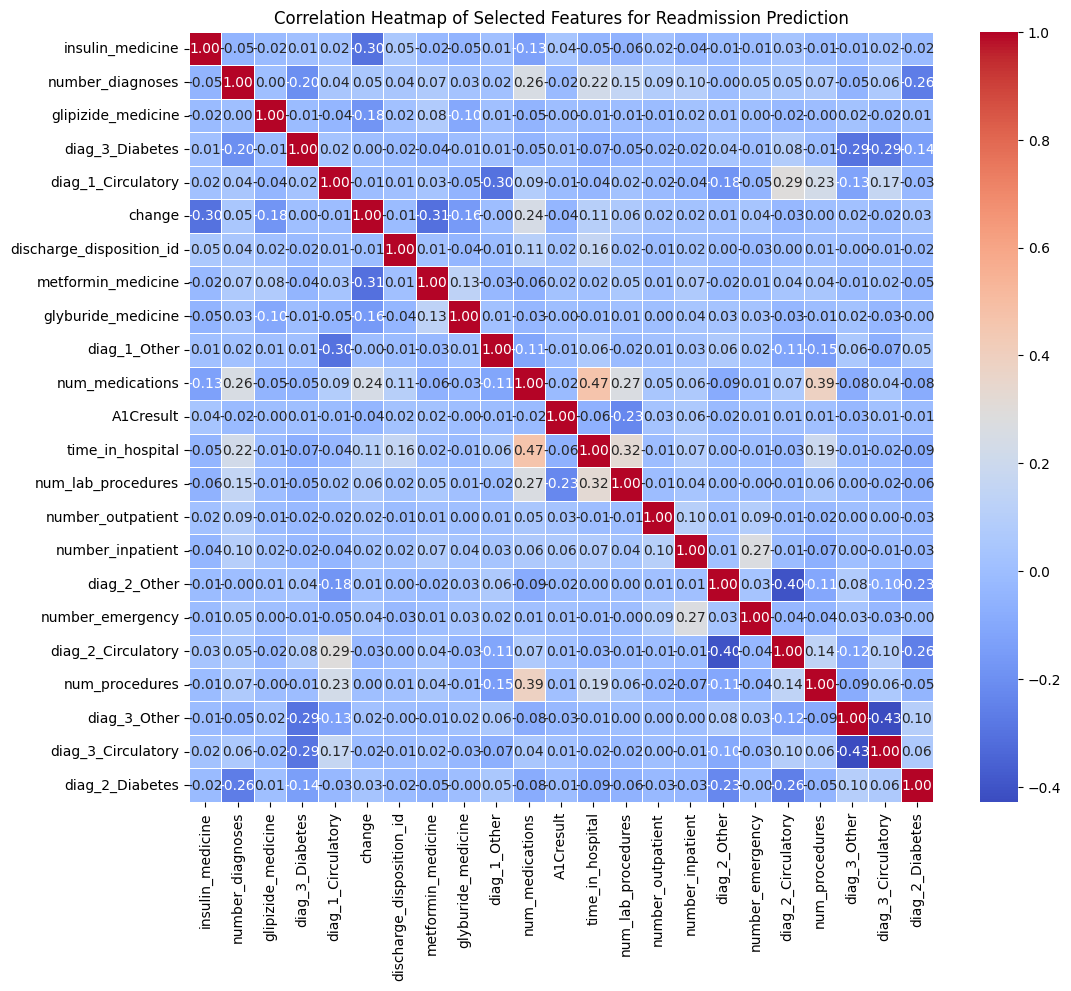

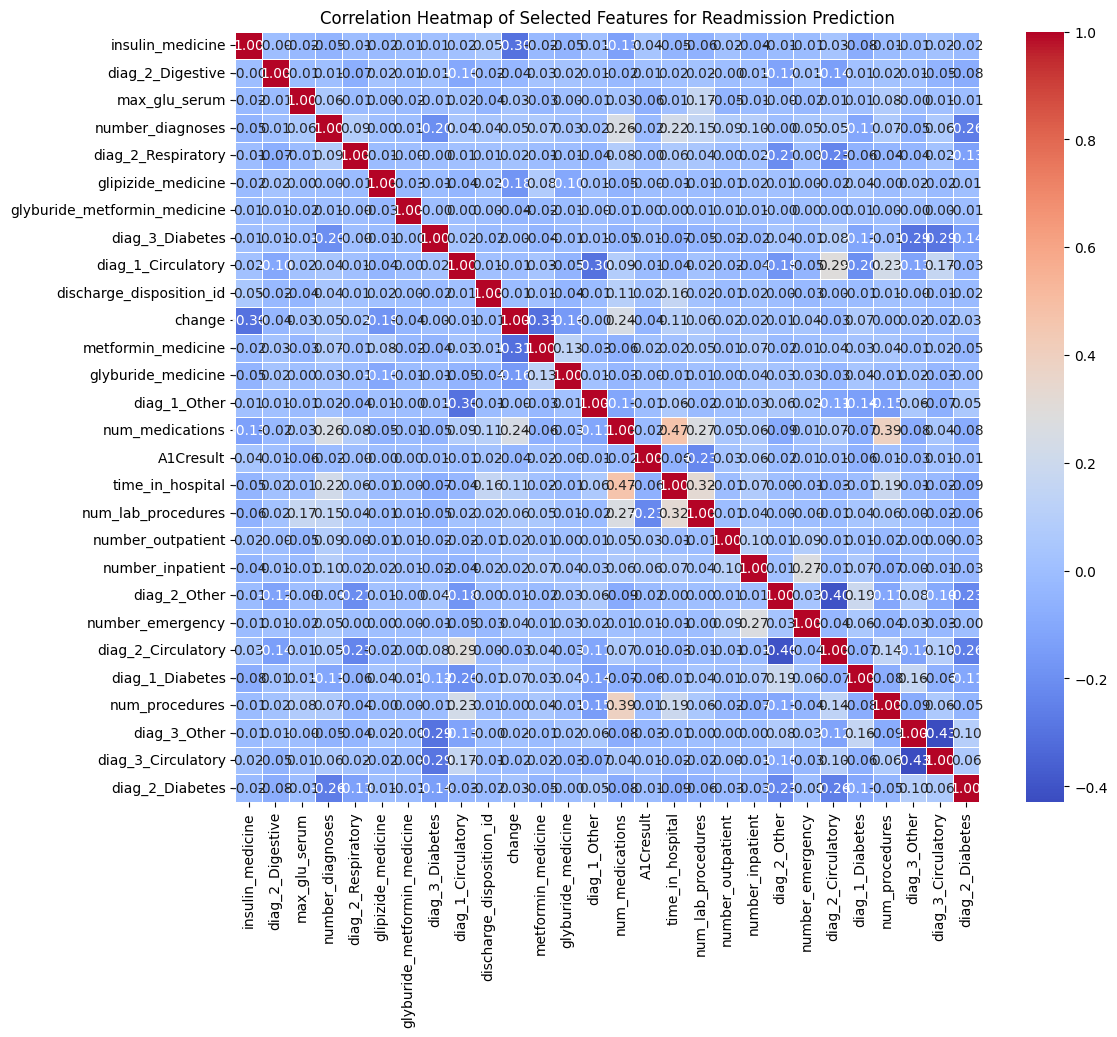

In [20]:
selected_columns_cherry_picked = df[list(top20_features_readmitted)]
selected_columns_all_demographics = df[list(all_features_related_to_demographics_readmitted)]

correlation_matrix_cherry_picked = selected_columns_cherry_picked.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_cherry_picked, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features for Readmission Prediction")
plt.show()

correlation_matrix_all = selected_columns_all_demographics.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features for Readmission Prediction")
plt.show()

In [21]:
#create a list of columns including columns with high importance, readmitted, and missed demographics
selected_columns_cherry_picked = list(selected_columns_cherry_picked) + ['readmitted', 'race', 'gender', 'race_Caucasian', 'race_Asian', 'race_AfricanAmerican', 'race_Hispanic', 'race_Other']
print(selected_columns_cherry_picked)

selected_columns_all_demographics = list(selected_columns_all_demographics) + ['readmitted', 'race', 'gender', 'race_Caucasian', 'race_Asian', 'race_AfricanAmerican', 'race_Hispanic', 'race_Other']
print(selected_columns_all_demographics)

['insulin_medicine', 'number_diagnoses', 'glipizide_medicine', 'diag_3_Diabetes', 'diag_1_Circulatory', 'change', 'discharge_disposition_id', 'metformin_medicine', 'glyburide_medicine', 'diag_1_Other', 'num_medications', 'A1Cresult', 'time_in_hospital', 'num_lab_procedures', 'number_outpatient', 'number_inpatient', 'diag_2_Other', 'number_emergency', 'diag_2_Circulatory', 'num_procedures', 'diag_3_Other', 'diag_3_Circulatory', 'diag_2_Diabetes', 'readmitted', 'race', 'gender', 'race_Caucasian', 'race_Asian', 'race_AfricanAmerican', 'race_Hispanic', 'race_Other']
['insulin_medicine', 'diag_2_Digestive', 'max_glu_serum', 'number_diagnoses', 'diag_2_Respiratory', 'glipizide_medicine', 'glyburide_metformin_medicine', 'diag_3_Diabetes', 'diag_1_Circulatory', 'discharge_disposition_id', 'change', 'metformin_medicine', 'glyburide_medicine', 'diag_1_Other', 'num_medications', 'A1Cresult', 'time_in_hospital', 'num_lab_procedures', 'number_outpatient', 'number_inpatient', 'diag_2_Other', 'number

In [22]:
df_extracted_features_cherry_picked = df[selected_columns_cherry_picked]

df_extracted_features_cherry_picked.columns = [col.replace("-", "_") for col in df_extracted_features_cherry_picked.columns]

df_extracted_features_cherry_picked.head()
df_extracted_features_cherry_picked.info()

selected_columns_all_demographics = df[selected_columns_all_demographics]

selected_columns_all_demographics.columns = [col.replace("-", "_") for col in selected_columns_all_demographics.columns]


<class 'pandas.core.frame.DataFrame'>
Index: 84568 entries, 0 to 10148
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   insulin_medicine          84568 non-null  int64
 1   number_diagnoses          84568 non-null  int64
 2   glipizide_medicine        84568 non-null  int64
 3   diag_3_Diabetes           84568 non-null  int64
 4   diag_1_Circulatory        84568 non-null  int64
 5   change                    84568 non-null  int64
 6   discharge_disposition_id  84568 non-null  int64
 7   metformin_medicine        84568 non-null  int64
 8   glyburide_medicine        84568 non-null  int64
 9   diag_1_Other              84568 non-null  int64
 10  num_medications           84568 non-null  int64
 11  A1Cresult                 84568 non-null  int64
 12  time_in_hospital          84568 non-null  int64
 13  num_lab_procedures        84568 non-null  int64
 14  number_outpatient         84568 non-null  i

In [23]:
for col in df_extracted_features_cherry_picked.columns:
    print(f"--- {col} ---")
    print(f"Unique values: {df_extracted_features_cherry_picked[col].nunique()}")
    print(f"Min: {df_extracted_features_cherry_picked[col].min()}")
    print(f"Max: {df_extracted_features_cherry_picked[col].max()}")
    print(f"Mean: {df_extracted_features_cherry_picked[col].mean()}")
    print("-" * 50)

--- insulin_medicine ---
Unique values: 4
Min: 0
Max: 3
Mean: 1.747717812884306
--------------------------------------------------
--- number_diagnoses ---
Unique values: 16
Min: 1
Max: 16
Mean: 7.439717150695299
--------------------------------------------------
--- glipizide_medicine ---
Unique values: 4
Min: 0
Max: 3
Mean: 2.6460245009932835
--------------------------------------------------
--- diag_3_Diabetes ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.1676520669756882
--------------------------------------------------
--- diag_1_Circulatory ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.2991793586226469
--------------------------------------------------
--- change ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.4615812127518683
--------------------------------------------------
--- discharge_disposition_id ---
Unique values: 26
Min: 1
Max: 28
Mean: 3.7493851102071707
--------------------------------------------------
--- metformin_medicine ---
Unique values: 4
Min: 0
Max: 3
Mean: 2.4377660

In [24]:
for col in selected_columns_all_demographics.columns:
    print(f"--- {col} ---")
    print(f"Unique values: {selected_columns_all_demographics[col].nunique()}")
    print(f"Min: {selected_columns_all_demographics[col].min()}")
    print(f"Max: {selected_columns_all_demographics[col].max()}")
    print(f"Mean: {selected_columns_all_demographics[col].mean()}")
    print("-" * 50)

--- insulin_medicine ---
Unique values: 4
Min: 0
Max: 3
Mean: 1.747717812884306
--------------------------------------------------
--- diag_2_Digestive ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.041315864156655
--------------------------------------------------
--- max_glu_serum ---
Unique values: 4
Min: 0
Max: 3
Mean: 2.8800373663797183
--------------------------------------------------
--- number_diagnoses ---
Unique values: 16
Min: 1
Max: 16
Mean: 7.439717150695299
--------------------------------------------------
--- diag_2_Respiratory ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.10699082395232239
--------------------------------------------------
--- glipizide_medicine ---
Unique values: 4
Min: 0
Max: 3
Mean: 2.6460245009932835
--------------------------------------------------
--- glyburide_metformin_medicine ---
Unique values: 4
Min: 0
Max: 3
Mean: 2.9793893671365055
--------------------------------------------------
--- diag_3_Diabetes ---
Unique values: 2
Min: 0
Max: 1
Mean: 0.

In [25]:
file_path = r'dataset/train_test_extracted_base/train_test_extracted_base_cherry_picked.csv'

df_extracted_features_cherry_picked.to_csv(file_path, index=False)

print(f"file has been saved in {file_path}.")

file has been saved in dataset/train_test_extracted_base/train_test_extracted_base_cherry_picked.csv.


In [26]:
file_path = r'dataset/train_test_extracted_base/train_test_extracted_base_all_demographics.csv'

selected_columns_all_demographics.to_csv(file_path, index=False)

print(f"file has been saved in {file_path}.")

file has been saved in dataset/train_test_extracted_base/train_test_extracted_base_all_demographics.csv.
